In [84]:
###################################
## Goal: Develop a basic outline so they we can devide and concur different parts of the project

## Note: All functions will be explicitly defined within this file for ease. In actual implementation it will be stored in a Function.py
###################################

In [85]:
##### Some Update Timelines
### 11/10/2024 - Implementing the monthly data into our series - Our Strategy now goes back to 1975.
### 11/18/2024 - Going back to 1973 - We will use a 3 Month Moving Average Strategy

In [86]:
'''
Roadmap

1.Build out a portfolio A based on a traditional 60/40 asset allocation with bloomberg ticker LUATTRUU Index for the 40% bond allocation.
The bloomberg terminal has monthly data starting 1973 and daily data starting in 1994. For the 60% equities, use bloomberg ticker SPXT Index with data starting in 1989 and
SPX Index going back to 1973 (it would be nice but not necessary to find S&P 500 total return data prior to 1989).

2.Record:
•	Compound annualized growth
•	Annualized volatility
•	Annualized downside deviation
•	Max drawdown each year
•	Annualized Sharpe Ratio
•	Annualized Sortino Ratio
•	Annualized Omega Ratio
•	Annualized Calmar Ratio

3.  Backtest an alternative Portfolio B with size of this allocation adjustable and using data going back to 1972.
Initially, the alternative strategy should be the XAU trade model outlined below, with the potential to test other alternative strategies in the future.
Record monthly performance of Portfolio B over the course of historical backtest and record the same overall performance metrics used for Portfolio A
Use ticker XAU Curncy and SPX Index. The trade trigger is XAU bull trend aligned simultaneously with SPX/XAU ratio bear trend.
The trade triggers and exits can be optimized based on any combination of smoothed moving average crosses. 5,20,63,252 using daily data. 4,13,52 using weekly closing price data.
3 and 12 for monthly closing data.

Trade trigger examples:
•	20 day < 252 day  for SPX/XAU and then on day 20 crosses > 252 for XAU, the model goes long XAU
•	4 week > 13 week for XAU and then when the 4 week crosses below the 13 week moving avg for SPX/XAU, the model goes long XAU

4.  Combine Portfolio A with Portfolio B to create Portfolio C using an initial 10% allocation (if 60/40 portfolio size = $100 then alt strategy =$10)
If initial findings do not reflect the XAU trade model being beneficial to adding resiliency to the initial portfolio, please reach out and we will provide other alternative strategy ideas.
'''

'\nRoadmap\n\n1.Build out a portfolio A based on a traditional 60/40 asset allocation with bloomberg ticker LUATTRUU Index for the 40% bond allocation.\nThe bloomberg terminal has monthly data starting 1973 and daily data starting in 1994. For the 60% equities, use bloomberg ticker SPXT Index with data starting in 1989 and\nSPX Index going back to 1973 (it would be nice but not necessary to find S&P 500 total return data prior to 1989).\n\n2.Record:\n•\tCompound annualized growth\n•\tAnnualized volatility\n•\tAnnualized downside deviation\n•\tMax drawdown each year\n•\tAnnualized Sharpe Ratio\n•\tAnnualized Sortino Ratio\n•\tAnnualized Omega Ratio\n•\tAnnualized Calmar Ratio\n\n3.  Backtest an alternative Portfolio B with size of this allocation adjustable and using data going back to 1972.\nInitially, the alternative strategy should be the XAU trade model outlined below, with the potential to test other alternative strategies in the future.\nRecord monthly performance of Portfolio B o

In [87]:
# Packages
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
import numpy as np
import pandas as pd
import quantstats as qs
import sys
import os

# Check directory
print("Current Working Directory:", os.getcwd())

# Set pandas display precision to three decimal places
pd.options.display.float_format = '{:.4f}'.format

Current Working Directory: /Users/liubenchen/Desktop/Low-Tide-Capital-Management


In [88]:
# Read in Data
data = pd.read_excel('/Users/liubenchen/Desktop/Low-Tide-Capital-Management/data/raw/equity_bond_gold.xlsx', na_values=['#N/A N/A'], sheet_name='equity_bond_gold_price')

# Rename the specified columns
data = data.rename(columns={
    'LUATTRUU Index': 'Bond',
    'SPXT Index': 'SP500_tr',
    'SPX Index': 'SP500',
    'XAU Curncy': 'Gold'
})

data.head(2)

,Dates,Bond,SP500_tr,SP500,Gold
0,1973-02-01,98.9900,NaN,114.7600,65.1400
1,1973-02-02,98.9900,NaN,114.3500,65.1400


In [89]:
data['Dates'] = pd.to_datetime(data['Dates'])
data.set_index('Dates', inplace=True)

In [90]:
'''
THESE ARE GENERAL NOTES ABOUT OUR DATA:
1) Our BOND DATA does not become daily until 03-01-1994
2) Our GOLD DATA does not become daily until 01-01-1975
-- THIS ABOVE FACT IS KEY -> Looking above we can see that this would have been a prime moment to invest in gold therefore we would like to showcase this in our portfolio
-- We will need to split our trend analysis that is for the first two years use monthly data and then convert into monthly
3) Our SP500 TR (which includes dividends) only begin in 09-11-1989
-- THIS creates a problem for reporting the true return of the base port (CURRENTLY WE ARE ONLY USING PRICE RETURNS)
'''

'\nTHESE ARE GENERAL NOTES ABOUT OUR DATA:\n1) Our BOND DATA does not become daily until 03-01-1994\n2) Our GOLD DATA does not become daily until 01-01-1975\n-- THIS ABOVE FACT IS KEY -> Looking above we can see that this would have been a prime moment to invest in gold therefore we would like to showcase this in our portfolio\n-- We will need to split our trend analysis that is for the first two years use monthly data and then convert into monthly\n3) Our SP500 TR (which includes dividends) only begin in 09-11-1989\n-- THIS creates a problem for reporting the true return of the base port (CURRENTLY WE ARE ONLY USING PRICE RETURNS)\n'

In [91]:
## We will no longer do this!

########################################
# Our GOLD DATA does not become daily until 01-01-1975
#data = data[data['Dates'] >= '1975-01-01']
########################################

# data.head(2)

In [92]:
# Although we will report with monthly data we need daily data to calculate the return of our strategy
def calc_percent(df):
    """
    Calculate the percentage change for each column in the DataFrame, ensuring DateTime indexing.
    """
    # Set 'Dates' column as the index and convert to DateTime if not already
    if 'Dates' in df.columns:
        df['Dates'] = pd.to_datetime(df['Dates'])
        df.set_index('Dates', inplace=True)

    # Create a new DataFrame for the percentage changes, maintaining the DateTime index
    df_percent = pd.DataFrame(index=df.index)

    # Calculate the percentage change for each column and add it to the new DataFrame
    for col in df.columns:
        df_percent[col + '_pctchange'] = df[col].pct_change().fillna(0)

    return df_percent


# Calculate percentage changes for each column starting from the second column onward
returns_daily = calc_percent(data)
returns_daily


,Bond_pctchange,SP500_tr_pctchange,SP500_pctchange,Gold_pctchange
Dates,,,,
1973-02-01,0.0000,0.0000,0.0000,0.0000
1973-02-02,0.0000,0.0000,-0.0036,0.0000
1973-02-05,0.0000,0.0000,-0.0010,0.0000
1973-02-06,0.0000,0.0000,0.0019,0.0000
1973-02-07,0.0000,0.0000,-0.0069,0.0000
...,...,...,...,...
2024-10-28,-0.0013,0.0027,0.0027,-0.0019
2024-10-29,0.0006,0.0016,0.0016,0.0118
2024-10-30,-0.0006,-0.0033,-0.0033,0.0046


In [93]:
### Now We will Report Monthly Returns Not Daily Returns so we need to adjust accoirdinly.

# Resample daily data to monthly frequency
def resample_to_monthly(df):
    """
    Resample daily data to monthly data by taking the last available data point in each month.
    """
    # Ensure 'Dates' is datetime and set as index
    if 'Dates' in df.columns:
        df['Dates'] = pd.to_datetime(df['Dates'])
        df.set_index('Dates', inplace=True)
    else:
        df.index = pd.to_datetime(df.index)

    # Resample to monthly data, taking the last available data point in each month
    df_monthly = df.resample('ME').last()
    return df_monthly

# Lets Get Our Monthly Data
monthly_data = resample_to_monthly(data)
monthly_data

,Bond,SP500_tr,SP500,Gold
Dates,,,,
1973-02-28,98.7300,NaN,111.6800,74.2000
1973-03-31,98.7300,NaN,111.5200,84.3700
1973-04-30,99.6600,NaN,106.9700,90.5000
1973-05-31,99.8800,NaN,104.9500,101.9600
1973-06-30,100.1500,NaN,104.2600,120.1200
...,...,...,...,...
2024-07-31,2306.8400,12052.0900,5522.3000,2447.6000
2024-08-31,2336.3500,12344.4300,5648.4000,2503.3900
2024-09-30,2364.4400,12608.0700,5762.4800,2634.5800


In [163]:
data_cta = pd.read_excel('/Users/liubenchen/Desktop/Low-Tide-Capital-Management/data/raw/NEIXCTA_Index.xlsx',
                             na_values=['#N/A N/A'],
                             parse_dates=['Date'],
                             index_col='Date')
data_cta.sort_index(inplace=True)
data_cta.head(2)

,NEIXCTA
Date,
1999-12-31,1000.0000
2000-01-03,996.7400


In [95]:
monthly_data = monthly_data.loc[data_cta.index[0]:]
monthly_data.head(2)

,Bond,SP500_tr,SP500,Gold
Dates,,,,
1999-12-31,958.3700,2021.4000,1469.2500,288.0000
2000-01-31,960.8700,1919.8400,1394.4600,283.5000


In [96]:
data

,Bond,SP500_tr,SP500,Gold
Dates,,,,
1973-02-01,98.9900,NaN,114.7600,65.1400
1973-02-02,98.9900,NaN,114.3500,65.1400
1973-02-05,98.9900,NaN,114.2300,65.1400
1973-02-06,98.9900,NaN,114.4500,65.1400
1973-02-07,98.9900,NaN,113.6600,65.1400
...,...,...,...,...
2024-10-28,2307.4800,12751.2200,5823.5200,2742.4600
2024-10-29,2308.7700,12771.8000,5832.9200,2774.7400
2024-10-30,2307.2800,12729.7300,5813.6700,2787.6100


In [97]:
def calc_monthly_percent_changes(df, from_daily=False):
    """
    Calculate the percentage change for each column in the DataFrame.

    Parameters:
    df : pandas DataFrame - The input DataFrame with monthly price data or daily return data.
    from_daily : bool - If True, calculates cumulative monthly returns from daily data.
                       If False, calculates percentage changes for monthly price data.
    """
    if from_daily:
        # Resample daily return data to get cumulative monthly returns
        df_monthly = (1 + df).resample('ME').prod() - 1  # Monthly cumulative return
    else:
        # Assume monthly price data, calculate the monthly percentage change
        df_monthly = df.pct_change().fillna(0)

    # Rename columns to indicate percentage change
    df_monthly.columns = [col + '_pctchange' for col in df_monthly.columns]

    return df_monthly

# Get Our Monthly Returns
returns_monthly = calc_monthly_percent_changes(monthly_data)

# Add a weighted 'ports_pctchange' column
returns_monthly['ports_pctchange'] = 0.6 * returns_monthly['SP500_pctchange'] + 0.4 * returns_monthly['Bond_pctchange']

returns_monthly.head(5)

,Bond_pctchange,SP500_tr_pctchange,SP500_pctchange,Gold_pctchange,ports_pctchange
Dates,,,,,
1999-12-31,0.0000,0.0000,0.0000,0.0000,0.0000
2000-01-31,0.0026,-0.0502,-0.0509,-0.0156,-0.0295
2000-02-29,0.0150,-0.0189,-0.0201,0.0307,-0.0060
2000-03-31,0.0199,0.0978,0.0967,-0.0449,0.0660
2000-04-30,-0.0032,-0.0301,-0.0308,-0.0198,-0.0197


In [98]:
# 1. Calculate Daily CTA Returns
cta_daily_returns = data_cta['NEIXCTA'].pct_change().fillna(0)
cta_daily_returns.name = 'CTA_pctchange'
cta_daily_returns

Date
1999-12-31    0.0000
2000-01-03   -0.0033
2000-01-04   -0.0098
2000-01-05   -0.0029
2000-01-06   -0.0018
               ...  
2024-11-29    0.0022
2024-12-02    0.0080
2024-12-03    0.0009
2024-12-04    0.0012
2024-12-05   -0.0027
Name: CTA_pctchange, Length: 6505, dtype: float64

In [99]:
cta_daily_returns = cta_daily_returns.to_frame()

In [100]:
# Calculate Cumulative Returns
cta_daily_returns['CTA_Cumulative_Returns'] = (1 + cta_daily_returns['CTA_pctchange']).cumprod() - 1
cta_daily_returns.head(2)

,CTA_pctchange,CTA_Cumulative_Returns
Date,,
1999-12-31,0.0000,0.0000
2000-01-03,-0.0033,-0.0033


In [101]:
# Merge the data on the index, which is the Date
data = pd.merge(data_cta, data, left_index=True, right_index=True, how='inner')
data.head(5)

,NEIXCTA,Bond,SP500_tr,SP500,Gold
1999-12-31,1000.0000,958.3700,2021.4000,1469.2500,288.0000
2000-01-03,996.7400,953.4700,2002.1100,1455.2200,289.0000
2000-01-04,986.9920,957.5600,1925.4100,1399.4200,282.2500
2000-01-05,984.1590,953.2000,1929.2800,1402.1100,280.0000
2000-01-06,982.3980,956.2200,1931.5100,1403.4500,281.1000


In [102]:
#### Function to Calculate Port Returns - Note this assumes we are taking in monthly data.

def calculate_max_drawdown(df, column_name):
    """
    Calculate the max drawdown for the entire period in a DataFrame with a DateTime index.
    """
    # Ensure the index is a DateTimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DateTimeIndex.")

    cumulative_returns = (1 + df[column_name]).cumprod()  # Calculate cumulative returns
    peak = cumulative_returns.cummax()  # Calculate rolling maximum of cumulative returns
    drawdown = (cumulative_returns - peak) / peak  # Calculate drawdown
    max_drawdown = drawdown.min()  # Return the maximum drawdown

    return max_drawdown



def calculate_performance_metrics(df, column_name):
    """
    Calculate various performance metrics for a given DataFrame with a DateTimeIndex.
    The annualization factor is set to 12 for monthly data.
    """
    annualization_factor = 12  # Set annualization factor to 12 for monthly data

    # Ensure the specified column exists
    if column_name not in df.columns:
        raise ValueError(f"The DataFrame must contain a '{column_name}' column.")

    # Drop missing values in returns
    returns = df[column_name].dropna()

    # Annualized returns (Compound Annualized Growth Rate - CAGR)
    cumulative_return = (1 + returns).prod() - 1
    years = len(returns) / annualization_factor
    cagr = (1 + cumulative_return) ** (1 / years) - 1

    # Annualized volatility
    annualized_volatility = returns.std() * np.sqrt(annualization_factor)

    # Annualized downside deviation (only considers negative returns)
    downside_returns = returns[returns < 0]
    annualized_downside_deviation = downside_returns.std() * np.sqrt(annualization_factor)

    # Annualized Sharpe Ratio (Assuming risk-free rate is zero)
    sharpe_ratio = cagr / annualized_volatility

    # Annualized Sortino Ratio
    sortino_ratio = cagr / annualized_downside_deviation

    # Annualized Omega Ratio (Using threshold of 0 for the numerator)
    positive_excess_returns = returns[returns > 0].sum()
    negative_excess_returns = abs(returns[returns < 0].sum())
    omega_ratio = positive_excess_returns / negative_excess_returns

    # Max drawdown for the full period
    max_drawdown = calculate_max_drawdown(df, column_name)

    # Annualized Calmar Ratio
    calmar_ratio = cagr / abs(max_drawdown)

    # Calculate win rate
    win_rate = len(returns[returns > 0]) / len(returns)

    # Prepare results as a DataFrame
    metrics_df = pd.DataFrame({
        'Metric': [
            'CAGR', 'Annualized Volatility', 'Annualized Downside Deviation',
            'Sharpe Ratio', 'Sortino Ratio', 'Omega Ratio', 'Max Drawdown',
            'Calmar Ratio', 'Win Rate'
        ],
        'Value': [
            cagr, annualized_volatility, annualized_downside_deviation, sharpe_ratio,
            sortino_ratio, omega_ratio, max_drawdown, calmar_ratio, win_rate
        ]
    })

    return metrics_df

# Now let us calculate the performance of our base model

base_port_performance = calculate_performance_metrics(returns_monthly, column_name='ports_pctchange')
base_port_performance


,Metric,Value
0,CAGR,0.0513
1,Annualized Volatility,0.0906
2,Annualized Downside Deviation,0.0658
3,Sharpe Ratio,0.5658
4,Sortino Ratio,0.7799
5,Omega Ratio,1.5665
6,Max Drawdown,-0.3191
7,Calmar Ratio,0.1607
8,Win Rate,0.6300


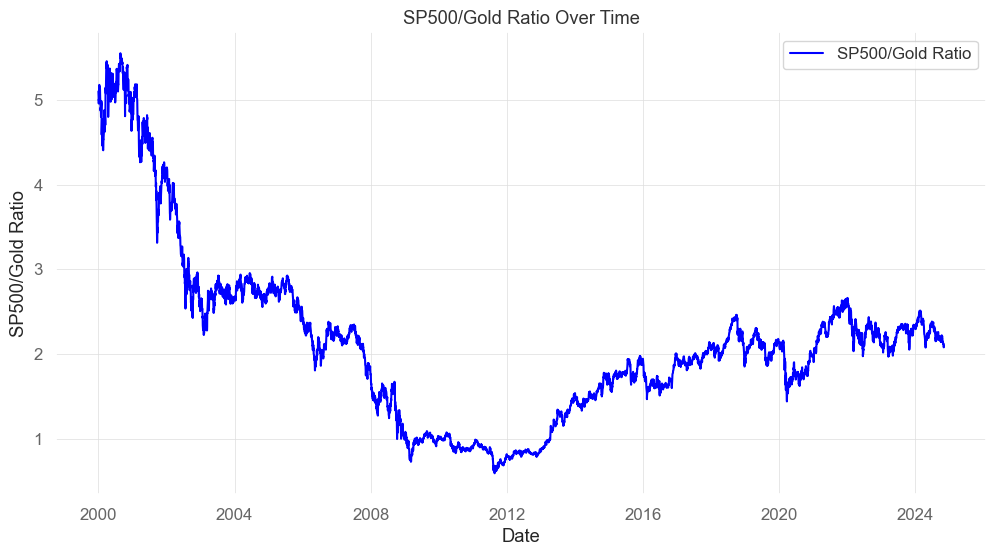

In [103]:
# Calculate the ratio of SP500 to Gold
data['SP500_Gold_Ratio'] = data['SP500'] / data['Gold']
data

# Plotting the SP500_Gold_Ratio
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['SP500_Gold_Ratio'], label='SP500/Gold Ratio', color='blue')
plt.title('SP500/Gold Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('SP500/Gold Ratio')
plt.legend()
plt.grid(True)
plt.show()

In [104]:
########################################################################################################################################################################################################################################################################################################################
########################################################################################################################################################################################################################################################################################################################
########################################################################################################################################################################################################################################################################################################################

In [105]:
# Functions That We Will Need!

In [106]:
def generate_signal_pre1975(price_series):
    """
    Generates trading signals for the pre-1975 period based on monthly data. Buy if the current price is greater than the 3-month moving average.

    Args:
        price_series (Series): The price series to analyze (monthly data).

    Returns:
        DataFrame: DataFrame containing the 'signal' column.
    """
    df = pd.DataFrame(price_series)

    # Calculate 3-month moving average
    df['ma_3'] = price_series.rolling(window=3).mean()

    # Generate signals: 1 if current price > 3-month moving average, 0 otherwise
    df['signal'] = np.where(df[price_series.name] > df['ma_3'], 1, 0)

    # Keep only the 'signal' column
    return df[['signal']]

In [107]:
def calculate_position_returns(signal_df, returns_series):
    """
    Calculates the returns based on holding positions according to signals, with a one-day delay.

    Args:
        signal_df (DataFrame): DataFrame containing the 'signal' column indicating the position (1, 0.5, or 0).
        returns_series (Series): Series of daily returns corresponding to the price series.

    Returns:
        DataFrame: DataFrame containing the shifted signals and the resulting position returns.
    """
    # Shift the signal by one day to implement the one-day delay
    signal_df['shifted_signal'] = signal_df['signal'].shift(1)

    # Calculate returns by multiplying returns with the delayed signal
    signal_df['position_returns'] = returns_series * signal_df['shifted_signal']

    # Optional: Calculate cumulative returns for a summary view
    # signal_df['cumulative_returns'] = (1 + signal_df['position_returns']).cumprod() - 1

    return signal_df[['shifted_signal', 'position_returns']]#, 'cumulative_returns']]

In [108]:
def calculate_ema_trend(price_series, short_period, long_period):
    df = pd.DataFrame(price_series)
    df['short_ema'] = price_series.ewm(span=short_period, adjust=False).mean()
    df['long_ema'] = price_series.ewm(span=long_period, adjust=False).mean()
    df['LT_trend'] = np.where(df['short_ema'] > df['long_ema'], 'bull', 'bear')
    return df[['short_ema', 'long_ema', 'LT_trend']]

In [109]:
def generate_signal_scenario1_updated(data, short_period, long_period):
    # Calculate EMA and LT trend for SPX/XAU ratio
    spx_gold_ratio_trend = calculate_ema_trend(data['SP500_Gold_Ratio'], short_period, long_period)
    # Calculate EMA and LT trend for Gold (XAU)
    gold_trend = calculate_ema_trend(data['Gold'], short_period, long_period)

    # Create DataFrame with trends
    df = pd.DataFrame(index=data.index)
    df['spx_gold_LT_trend'] = spx_gold_ratio_trend['LT_trend']
    df['gold_LT_trend'] = gold_trend['LT_trend']

    # Initialize signal column
    df['signal'] = 0  # Default to no position

    # Identify entry points
    df['entry'] = ((df['spx_gold_LT_trend'] == 'bear') & (df['gold_LT_trend'] == 'bull')) & \
                  (~((df['spx_gold_LT_trend'].shift(1) == 'bear') & (df['gold_LT_trend'].shift(1) == 'bull')))

    # Identify exit points
    df['exit'] = (df['gold_LT_trend'] == 'bear') & (df['gold_LT_trend'].shift(1) != 'bear')

    # Generate signal by maintaining position between entry and exit
    df['signal'] = 0
    position = 0
    for i in df.index:
        if df.loc[i, 'entry']:
            position = 1  # Enter position
        elif df.loc[i, 'exit']:
            position = 0  # Exit position
        df.loc[i, 'signal'] = position  # Maintain position

    return df['signal']


In [110]:
def generate_signal_scenario2_updated(data, short_period, long_period):
    # Calculate EMA and LT trend for Gold (XAU)
    gold_trend = calculate_ema_trend(data['Gold'], short_period, long_period)
    # Calculate EMA and LT trend for SPX/XAU ratio
    spx_gold_ratio_trend = calculate_ema_trend(data['SP500_Gold_Ratio'], short_period, long_period)

    # Create DataFrame with trends
    df = pd.DataFrame(index=data.index)
    df['gold_LT_trend'] = gold_trend['LT_trend']
    df['spx_gold_LT_trend'] = spx_gold_ratio_trend['LT_trend']

    # Initialize signal column
    df['signal'] = 0  # Default to no position

    # Identify entry points
    df['entry'] = ((df['gold_LT_trend'] == 'bull') & (df['spx_gold_LT_trend'] == 'bear')) & \
                  (~((df['gold_LT_trend'].shift(1) == 'bull') & (df['spx_gold_LT_trend'].shift(1) == 'bear')))

    # Identify exit points
    df['exit'] = (df['spx_gold_LT_trend'] == 'bull') & (df['spx_gold_LT_trend'].shift(1) != 'bull')

    # Generate signal by maintaining position between entry and exit
    df['signal'] = 0
    position = 0
    for i in df.index:
        if df.loc[i, 'entry']:
            position = 1  # Enter position
        elif df.loc[i, 'exit']:
            position = 0  # Exit position
        df.loc[i, 'signal'] = position  # Maintain position

    return df['signal']




In [111]:
def generate_signal_scenario3(data, short_period, long_period):
    """
    Generates signals for Scenario 3.
    """
    # Calculate EMA and LT trend for Gold (XAU)
    gold_trend = calculate_ema_trend(data['Gold'], short_period, long_period)

    # Create DataFrame with LT trend
    df = pd.DataFrame(index=data.index)
    df['gold_LT_trend'] = gold_trend['LT_trend']

    # Initialize signal column
    df['signal'] = 0  # Default to no position

    # Generate Buy Signals
    df['signal'] = np.where(df['gold_LT_trend'] == 'bull', 1, 0)

    return df['signal']

In [112]:
data

,NEIXCTA,Bond,SP500_tr,SP500,Gold,SP500_Gold_Ratio
1999-12-31,1000.0000,958.3700,2021.4000,1469.2500,288.0000,5.1016
2000-01-03,996.7400,953.4700,2002.1100,1455.2200,289.0000,5.0354
2000-01-04,986.9920,957.5600,1925.4100,1399.4200,282.2500,4.9581
2000-01-05,984.1590,953.2000,1929.2800,1402.1100,280.0000,5.0075
2000-01-06,982.3980,956.2200,1931.5100,1403.4500,281.1000,4.9927
...,...,...,...,...,...,...
2024-10-28,2867.8270,2307.4800,12751.2200,5823.5200,2742.4600,2.1235
2024-10-29,2875.7110,2308.7700,12771.8000,5832.9200,2774.7400,2.1022
2024-10-30,2852.2730,2307.2800,12729.7300,5813.6700,2787.6100,2.0855
2024-10-31,2823.1450,2308.1400,12493.7400,5705.4500,2743.9700,2.0793


In [113]:
def generate_signal_scenario4(data, short_period, long_period):
    # Calculate EMA and LT trend for SPX ratio
    spx_ratio_trend = calculate_ema_trend(data['SP500'], short_period, long_period)
    # Calculate EMA and LT trend for CTA (	NEIXCTA	)
    cta_trend = calculate_ema_trend(data['NEIXCTA'], short_period, long_period)

    # Create DataFrame with trends
    df = pd.DataFrame(index=data.index)
    df['spx_LT_trend'] = spx_ratio_trend['LT_trend']
    df['cta_LT_trend'] = cta_trend['LT_trend']

    # Initialize signal column
    df['signal'] = 0  # Default to no position

    # spy 
    df['entry'] = ((df['spx_LT_trend'] == 'bear') & (df['cta_LT_trend'] == 'bull')) & \
                  (~((df['spx_LT_trend'].shift(1) == 'bear') & (df['cta_LT_trend'].shift(1) == 'bull')))

    # Identify exit points
    df['exit'] = (df['cta_LT_trend'] == 'bear') & (df['cta_LT_trend'].shift(1) != 'bear')

    # Generate signal by maintaining position between entry and exit
    df['signal'] = 0
    position = 0
    for i in df.index:
        if df.loc[i, 'entry']:
            position = 1  # Enter position
        elif df.loc[i, 'exit']:
            position = 0  # Exit position
        df.loc[i, 'signal'] = position  # Maintain position

    return df['signal']

In [114]:
def generate_signal_scenario5(data, short_period, long_period):
    # Calculate EMA and LT trend for CTA
    cta_trend = calculate_ema_trend(data['NEIXCTA'], short_period, long_period)
    # Calculate EMA and LT trend for SPX ratio
    spx_ratio_trend = calculate_ema_trend(data['SP500'], short_period, long_period)

    # Create DataFrame with trends
    df = pd.DataFrame(index=data.index)
    df['cta_LT_trend'] = cta_trend['LT_trend']
    df['spx_LT_trend'] = spx_ratio_trend['LT_trend']

    # Initialize signal column
    df['signal'] = 0  # Default to no position

    # Identify entry points
    df['entry'] = ((df['cta_LT_trend'] == 'bull') & (df['spx_LT_trend'] == 'bear')) & \
                  (~((df['cta_LT_trend'].shift(1) == 'bull') & (df['spx_LT_trend'].shift(1) == 'bear')))

    # Identify exit points
    df['exit'] = (df['spx_LT_trend'] == 'bull') & (df['spx_LT_trend'].shift(1) != 'bull')

    # Generate signal by maintaining position between entry and exit
    df['signal'] = 0
    position = 0
    for i in df.index:
        if df.loc[i, 'entry']:
            position = 1  # Enter position
        elif df.loc[i, 'exit']:
            position = 0  # Exit position
        df.loc[i, 'signal'] = position  # Maintain position

    return df['signal']

In [115]:
def generate_signal_scenario6(data, short_period, long_period):
    """
    Generates signals for Scenario 3.
    """
    # Calculate EMA and LT trend for CTA
    cta_trend = calculate_ema_trend(data['NEIXCTA'], short_period, long_period)

    # Create DataFrame with LT trend
    df = pd.DataFrame(index=data.index)
    df['cta_LT_trend'] = cta_trend['LT_trend']

    # Initialize signal column
    df['signal'] = 0  # Default to no position

    # Generate Buy Signals
    df['signal'] = np.where(df['cta_LT_trend'] == 'bull', 1, 0)

    return df['signal']

In [116]:
data

,NEIXCTA,Bond,SP500_tr,SP500,Gold,SP500_Gold_Ratio
1999-12-31,1000.0000,958.3700,2021.4000,1469.2500,288.0000,5.1016
2000-01-03,996.7400,953.4700,2002.1100,1455.2200,289.0000,5.0354
2000-01-04,986.9920,957.5600,1925.4100,1399.4200,282.2500,4.9581
2000-01-05,984.1590,953.2000,1929.2800,1402.1100,280.0000,5.0075
2000-01-06,982.3980,956.2200,1931.5100,1403.4500,281.1000,4.9927
...,...,...,...,...,...,...
2024-10-28,2867.8270,2307.4800,12751.2200,5823.5200,2742.4600,2.1235
2024-10-29,2875.7110,2308.7700,12771.8000,5832.9200,2774.7400,2.1022
2024-10-30,2852.2730,2307.2800,12729.7300,5813.6700,2787.6100,2.0855
2024-10-31,2823.1450,2308.1400,12493.7400,5705.4500,2743.9700,2.0793


In [117]:
# Define EMA periods
short_period = 63
long_period = 252

# Scenario 1 Updated Signals
signal_scenario1 = generate_signal_scenario1_updated(data, short_period, long_period)

# Scenario 2 Updated Signals
signal_scenario2 = generate_signal_scenario2_updated(data, short_period, long_period)

# Scenario 3 remains the same as before
signal_scenario3 = generate_signal_scenario3(data, short_period, long_period)

In [118]:
# Define EMA periods
short_period = 63
long_period = 252

# Scenario 1 Updated Signals
signal_scenario4 = generate_signal_scenario4(data, short_period, long_period)

# Scenario 2 Updated Signals
signal_scenario5 = generate_signal_scenario5(data, short_period, long_period)

# Scenario 3 remains the same as before
signal_scenario6 = generate_signal_scenario6(data, short_period, long_period)

In [119]:
# Ensure 'Gold_pctchange' is aligned with 'data' index
gold_returns_daily = returns_daily['Gold_pctchange'].reindex(data.index).fillna(0)

# Scenario 1 Position Returns
position_returns_scenario1 = calculate_position_returns(
    pd.DataFrame(signal_scenario1), gold_returns_daily
)

# Scenario 2 Position Returns
position_returns_scenario2 = calculate_position_returns(
    pd.DataFrame(signal_scenario2), gold_returns_daily
)

# Scenario 3 Position Returns
position_returns_scenario3 = calculate_position_returns(
    pd.DataFrame(signal_scenario3), gold_returns_daily
)


In [120]:
# Ensure 'Gold_pctchange' is aligned with 'data' index
cta_returns_daily = cta_daily_returns['CTA_pctchange'].reindex(data.index).fillna(0)

# Scenario 4 Position Returns
position_returns_scenario4 = calculate_position_returns(
    pd.DataFrame(signal_scenario4), cta_returns_daily
)

# Scenario 5 Position Returns
position_returns_scenario5 = calculate_position_returns(
    pd.DataFrame(signal_scenario5), cta_returns_daily
)

# Scenario 6 Position Returns
position_returns_scenario6 = calculate_position_returns(
    pd.DataFrame(signal_scenario6), cta_returns_daily
)


In [121]:
cta_daily_returns

,CTA_pctchange,CTA_Cumulative_Returns
Date,,
1999-12-31,0.0000,0.0000
2000-01-03,-0.0033,-0.0033
2000-01-04,-0.0098,-0.0130
2000-01-05,-0.0029,-0.0158
2000-01-06,-0.0018,-0.0176
...,...,...
2024-11-29,0.0022,1.8750
2024-12-02,0.0080,1.8980
2024-12-03,0.0009,1.9006


In [122]:
def resample_to_monthly_returns(position_returns_df):
    # Calculate cumulative daily returns
    position_returns_df['cumulative_return'] = (1 + position_returns_df['position_returns']).cumprod()

    # Resample to monthly by taking the last cumulative return of each month
    monthly_cumulative_returns = position_returns_df['cumulative_return'].resample('ME').last()

    # Calculate monthly returns from cumulative returns
    monthly_returns = monthly_cumulative_returns.pct_change().fillna(0)
    monthly_returns.name = 'position_returns'

    return monthly_returns


In [123]:
# Scenario 1 Monthly Returns
monthly_returns_scenario1 = resample_to_monthly_returns(position_returns_scenario1)

# Scenario 2 Monthly Returns
monthly_returns_scenario2 = resample_to_monthly_returns(position_returns_scenario2)

# Scenario 3 Monthly Returns
monthly_returns_scenario3 = resample_to_monthly_returns(position_returns_scenario3)


In [124]:
# Scenario 4 Monthly Returns
monthly_returns_scenario4 = resample_to_monthly_returns(position_returns_scenario4)

# Scenario 5 Monthly Returns
monthly_returns_scenario5 = resample_to_monthly_returns(position_returns_scenario5)

# Scenario 6 Monthly Returns
monthly_returns_scenario6 = resample_to_monthly_returns(position_returns_scenario6)


In [125]:
def calculate_performance_metrics_from_series(returns_series):
    """
    Calculate performance metrics from a returns Series.
    """
    df = pd.DataFrame({'position_returns': returns_series})
    return calculate_performance_metrics(df, 'position_returns')


In [126]:
# Scenario 1 Performance
performance_scenario1 = calculate_performance_metrics_from_series(monthly_returns_scenario1)

# Scenario 2 Performance
performance_scenario2 = calculate_performance_metrics_from_series(monthly_returns_scenario2)

# Scenario 3 Performance
performance_scenario3 = calculate_performance_metrics_from_series(monthly_returns_scenario3)

# Scenario 4 Performance
performance_scenario4 = calculate_performance_metrics_from_series(monthly_returns_scenario4)

# Scenario 5 Performance
performance_scenario5 = calculate_performance_metrics_from_series(monthly_returns_scenario5)

# Scenario 6 Performance
performance_scenario6 = calculate_performance_metrics_from_series(monthly_returns_scenario6)


In [127]:
# Combine performance metrics
combined_performance = pd.concat(
    [
        performance_scenario1.set_index('Metric'),
        performance_scenario2.set_index('Metric'),
        performance_scenario3.set_index('Metric'),
        performance_scenario4.set_index('Metric'),
        performance_scenario5.set_index('Metric'),
        performance_scenario6.set_index('Metric')
    ],
    axis=1,
    keys=['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4', 'Scenario 5', 'Scenario 6']
)

combined_performance


,Scenario 1,Scenario 2,Scenario 3,Scenario 4,Scenario 5,Scenario 6
,Value,Value,Value,Value,Value,Value
Metric,,,,,,
CAGR,0.0782,0.0682,0.0786,0.0064,0.0090,0.0237
Annualized Volatility,0.1365,0.1314,0.1401,0.0547,0.0515,0.0768
Annualized Downside Deviation,0.0960,0.0940,0.0929,0.0568,0.0621,0.0501
Sharpe Ratio,0.5725,0.5193,0.5611,0.1179,0.1747,0.3090
Sortino Ratio,0.8143,0.7256,0.8458,0.1134,0.1449,0.4740
Omega Ratio,1.7509,1.7386,1.6821,1.2030,1.3286,1.3331
Max Drawdown,-0.2625,-0.2612,-0.2625,-0.1516,-0.1449,-0.1480
Calmar Ratio,0.2978,0.2613,0.2995,0.0425,0.0621,0.1604


In [128]:
# Ensure signals are aligned and converted to numeric
signal_scenario1 = signal_scenario1.astype(float)
signal_scenario2 = signal_scenario2.astype(float)
signal_scenario3 = signal_scenario3.astype(float)

# Calculate combined signal as 0.33 times each individual signal
combined_signal = 0.33 * signal_scenario1 + 0.33 * signal_scenario2 + 0.33 * signal_scenario3

# Optionally, cap the combined_signal at 1
combined_signal = combined_signal.clip(upper=1.0)

# Calculate position returns for combined signal
position_returns_combined = calculate_position_returns(
    pd.DataFrame(combined_signal, columns=['signal']), gold_returns_daily
)

# Resample to monthly returns
monthly_returns_combined = resample_to_monthly_returns(position_returns_combined)

# Calculate performance metrics
performance_combined = calculate_performance_metrics_from_series(monthly_returns_combined)

# Add to the combined performance DataFrame
combined_performance = pd.concat(
    [
        performance_scenario1.set_index('Metric'),
        performance_scenario2.set_index('Metric'),
        performance_scenario3.set_index('Metric'),
        performance_combined.set_index('Metric')
    ],
    axis=1,
    keys=['Scenario 1', 'Scenario 2', 'Scenario 3', 'Combined']
)

# Display the combined performance metrics
combined_performance


,Scenario 1,Scenario 2,Scenario 3,Combined
,Value,Value,Value,Value
Metric,,,,
CAGR,0.0782,0.0682,0.0786,0.0750
Annualized Volatility,0.1365,0.1314,0.1401,0.1299
Annualized Downside Deviation,0.0960,0.0940,0.0929,0.0900
Sharpe Ratio,0.5725,0.5193,0.5611,0.5774
Sortino Ratio,0.8143,0.7256,0.8458,0.8333
Omega Ratio,1.7509,1.7386,1.6821,1.7334
Max Drawdown,-0.2625,-0.2612,-0.2625,-0.2496
Calmar Ratio,0.2978,0.2613,0.2995,0.3004


In [129]:
# Extract Gold monthly returns from returns_monthly
gold_returns_monthly = returns_monthly['Gold_pctchange']

In [130]:
# Prepare the DataFrame for the gold strategy
gold_strategy_long = pd.DataFrame({'position_returns': gold_returns_monthly})

In [131]:
def calculate_cumulative_returns(monthly_returns):
    """
    Calculates cumulative returns from a Series of monthly returns.

    Args:
        monthly_returns (pd.Series): Series of monthly returns.

    Returns:
        pd.Series: Series of cumulative returns.
    """
    cumulative_returns = (1 + monthly_returns).cumprod()
    return cumulative_returns

# Scenario 1 Cumulative Returns
cumulative_returns_scenario1 = calculate_cumulative_returns(monthly_returns_scenario1)

# Scenario 2 Cumulative Returns
cumulative_returns_scenario2 = calculate_cumulative_returns(monthly_returns_scenario2)

# Scenario 3 Cumulative Returns
cumulative_returns_scenario3 = calculate_cumulative_returns(monthly_returns_scenario3)

# Scenario 4 Cumulative Returns
cumulative_returns_scenario4 = calculate_cumulative_returns(monthly_returns_scenario4)

# Scenario 5 Cumulative Returns
cumulative_returns_scenario5 = calculate_cumulative_returns(monthly_returns_scenario5)

# Scenario 6 Cumulative Returns
cumulative_returns_scenario6 = calculate_cumulative_returns(monthly_returns_scenario6)

# Combined Strategy Cumulative Returns
cumulative_returns_combined = calculate_cumulative_returns(monthly_returns_combined)

# Calculate cumulative returns for the gold long-only strategy
cumulative_returns_gold = calculate_cumulative_returns(gold_returns_monthly)


In [132]:
# Calculate performance metrics for the gold long-only strategy
performance_gold = calculate_performance_metrics(
    gold_strategy_long, column_name='position_returns'
)


In [133]:
# Add gold performance metrics to the combined performance DataFrame
combined_performance = pd.concat(
    [
        performance_scenario1.set_index('Metric'),
        performance_scenario2.set_index('Metric'),
        performance_scenario3.set_index('Metric'),
        performance_combined.set_index('Metric'),
        performance_gold.set_index('Metric'),
        performance_scenario4.set_index('Metric'),
        performance_scenario5.set_index('Metric'),
        performance_scenario6.set_index('Metric')
    ],
    axis=1,
    keys=['Scenario 1', 'Scenario 2', 'Scenario 3', 'Combined', 'Gold Long-Only', 'Scenario 4', 'Scenario 5', 'Scenario 6',],
)

# Display the updated combined performance metrics
combined_performance


,Scenario 1,Scenario 2,Scenario 3,Combined,Gold Long-Only,Scenario 4,Scenario 5,Scenario 6
,Value,Value,Value,Value,Value,Value,Value,Value
Metric,,,,,,,,
CAGR,0.0782,0.0682,0.0786,0.0750,0.0942,0.0064,0.0090,0.0237
Annualized Volatility,0.1365,0.1314,0.1401,0.1299,0.1601,0.0547,0.0515,0.0768
Annualized Downside Deviation,0.0960,0.0940,0.0929,0.0900,0.0916,0.0568,0.0621,0.0501
Sharpe Ratio,0.5725,0.5193,0.5611,0.5774,0.5887,0.1179,0.1747,0.3090
Sortino Ratio,0.8143,0.7256,0.8458,0.8333,1.0291,0.1134,0.1449,0.4740
Omega Ratio,1.7509,1.7386,1.6821,1.7334,1.6097,1.2030,1.3286,1.3331
Max Drawdown,-0.2625,-0.2612,-0.2625,-0.2496,-0.4188,-0.1516,-0.1449,-0.1480
Calmar Ratio,0.2978,0.2613,0.2995,0.3004,0.2250,0.0425,0.0621,0.1604


In [134]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


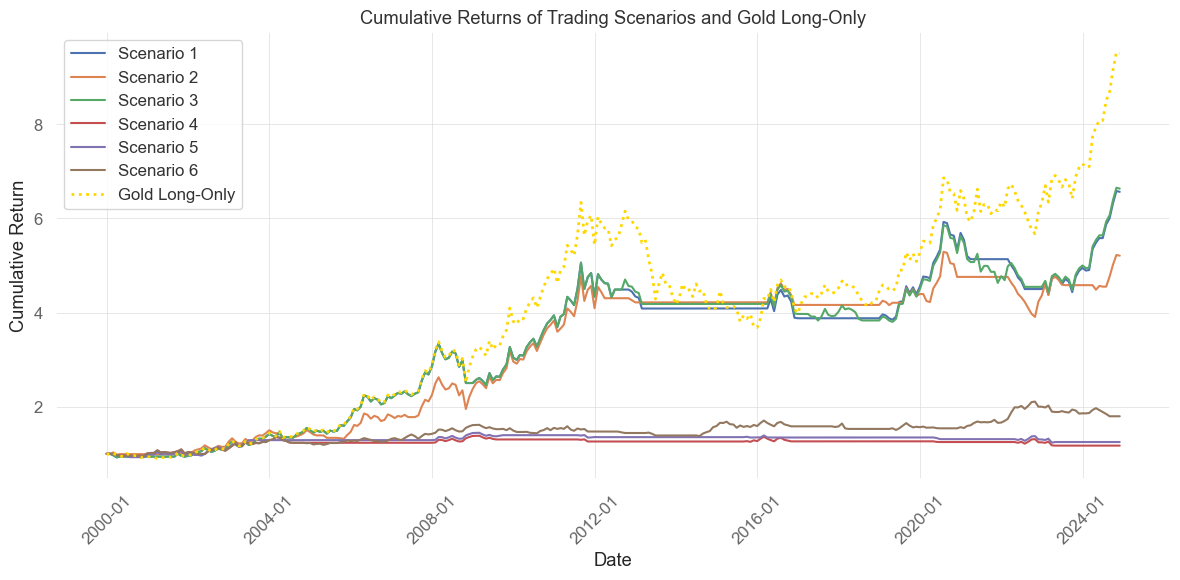

In [159]:
# Plotting
plt.figure(figsize=(12, 6))

plt.plot(cumulative_returns_scenario1.index, cumulative_returns_scenario1, label='Scenario 1')
plt.plot(cumulative_returns_scenario2.index, cumulative_returns_scenario2, label='Scenario 2')
plt.plot(cumulative_returns_scenario3.index, cumulative_returns_scenario3, label='Scenario 3')
plt.plot(cumulative_returns_scenario4.index, cumulative_returns_scenario4, label='Scenario 4')
plt.plot(cumulative_returns_scenario5.index, cumulative_returns_scenario5, label='Scenario 5')
plt.plot(cumulative_returns_scenario6.index, cumulative_returns_scenario6, label='Scenario 6')

# plt.plot(
#     cumulative_returns_combined.index,
#     cumulative_returns_combined,
#     label='Combined Strategy',
#     linewidth=2,
#     linestyle='--',
# )
plt.plot(
    cumulative_returns_gold.index,
    cumulative_returns_gold,
    label='Gold Long-Only',
    linewidth=2,
    linestyle=':',
    color='gold',
)

# Formatting
plt.title('Cumulative Returns of Trading Scenarios and Gold Long-Only')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)

# Date formatting for x-axis
date_format = mdates.DateFormatter('%Y-%m')
ax = plt.gca()
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [136]:
#####################################################################################################################################################################################################################################################################################################################################################################
#####################################################################################################################################################################################################################################################################################################################################################################

In [137]:
short_period_ST = 20
long_period_ST = 63

In [138]:
def generate_signal_scenario7(data, short_period, long_period):
    # Calculate EMA and ST trend for SPX/XAU ratio
    spx_gold_ratio_trend = calculate_ema_trend(data['SP500_Gold_Ratio'], short_period, long_period)
    # Calculate EMA and ST trend for Gold (XAU)
    gold_trend = calculate_ema_trend(data['Gold'], short_period, long_period)

    # Create DataFrame with trends
    df = pd.DataFrame(index=data.index)
    df['spx_gold_ST_trend'] = spx_gold_ratio_trend['LT_trend']
    df['gold_ST_trend'] = gold_trend['LT_trend']

    # Initialize signal column
    df['signal'] = 0  # Default to no position

    # Identify entry points
    df['entry'] = ((df['spx_gold_ST_trend'] == 'bear') & (df['gold_ST_trend'] == 'bull')) & \
                  (~((df['spx_gold_ST_trend'].shift(1) == 'bear') & (df['gold_ST_trend'].shift(1) == 'bull')))

    # Identify exit points
    df['exit'] = (df['gold_ST_trend'] == 'bear') & (df['gold_ST_trend'].shift(1) != 'bear')

    # Generate signal by maintaining position between entry and exit
    df['signal'] = 0
    position = 0
    for i in df.index:
        if df.loc[i, 'entry']:
            position = 1  # Enter position
        elif df.loc[i, 'exit']:
            position = 0  # Exit position
        df.loc[i, 'signal'] = position  # Maintain position

    return df['signal']


In [139]:
def generate_signal_scenario8(data, short_period, long_period):
    # Calculate EMA and ST trend for Gold (XAU)
    gold_trend = calculate_ema_trend(data['Gold'], short_period, long_period)
    # Calculate EMA and ST trend for SPX/XAU ratio
    spx_gold_ratio_trend = calculate_ema_trend(data['SP500_Gold_Ratio'], short_period, long_period)

    # Create DataFrame with trends
    df = pd.DataFrame(index=data.index)
    df['gold_ST_trend'] = gold_trend['LT_trend']
    df['spx_gold_ST_trend'] = spx_gold_ratio_trend['LT_trend']

    # Initialize signal column
    df['signal'] = 0  # Default to no position

    # Identify entry points
    df['entry'] = ((df['gold_ST_trend'] == 'bull') & (df['spx_gold_ST_trend'] == 'bear')) & \
                  (~((df['gold_ST_trend'].shift(1) == 'bull') & (df['spx_gold_ST_trend'].shift(1) == 'bear')))

    # Identify exit points
    df['exit'] = (df['spx_gold_ST_trend'] == 'bull') & (df['spx_gold_ST_trend'].shift(1) != 'bull')

    # Generate signal by maintaining position between entry and exit
    df['signal'] = 0
    position = 0
    for i in df.index:
        if df.loc[i, 'entry']:
            position = 1  # Enter position
        elif df.loc[i, 'exit']:
            position = 0  # Exit position
        df.loc[i, 'signal'] = position  # Maintain position

    return df['signal']


In [140]:
def generate_signal_scenario9(data, short_period, long_period):
    # Calculate EMA and ST trend for Gold (XAU)
    gold_trend = calculate_ema_trend(data['Gold'], short_period, long_period)

    # Create DataFrame with trends
    df = pd.DataFrame(index=data.index)
    df['gold_ST_trend'] = gold_trend['LT_trend']

    # Initialize signal column
    df['signal'] = 0  # Default to no position

    # Identify entry points
    df['entry'] = (df['gold_ST_trend'] == 'bull') & (df['gold_ST_trend'].shift(1) != 'bull')

    # Identify exit points
    df['exit'] = (df['gold_ST_trend'] == 'bear') & (df['gold_ST_trend'].shift(1) != 'bear')

    # Generate signal by maintaining position between entry and exit
    df['signal'] = 0
    position = 0
    for i in df.index:
        if df.loc[i, 'entry']:
            position = 1  # Enter position
        elif df.loc[i, 'exit']:
            position = 0  # Exit position
        df.loc[i, 'signal'] = position  # Maintain position

    return df['signal']


In [141]:
data

,NEIXCTA,Bond,SP500_tr,SP500,Gold,SP500_Gold_Ratio
1999-12-31,1000.0000,958.3700,2021.4000,1469.2500,288.0000,5.1016
2000-01-03,996.7400,953.4700,2002.1100,1455.2200,289.0000,5.0354
2000-01-04,986.9920,957.5600,1925.4100,1399.4200,282.2500,4.9581
2000-01-05,984.1590,953.2000,1929.2800,1402.1100,280.0000,5.0075
2000-01-06,982.3980,956.2200,1931.5100,1403.4500,281.1000,4.9927
...,...,...,...,...,...,...
2024-10-28,2867.8270,2307.4800,12751.2200,5823.5200,2742.4600,2.1235
2024-10-29,2875.7110,2308.7700,12771.8000,5832.9200,2774.7400,2.1022
2024-10-30,2852.2730,2307.2800,12729.7300,5813.6700,2787.6100,2.0855
2024-10-31,2823.1450,2308.1400,12493.7400,5705.4500,2743.9700,2.0793


In [142]:
def generate_signal_scenario10(data, short_period, long_period):
    # Calculate EMA and ST trend for SPX ratio
    spx_ratio_trend = calculate_ema_trend(data['SP500'], short_period, long_period)
    # Calculate EMA and ST trend for CTA
    cta_trend = calculate_ema_trend(data['NEIXCTA'], short_period, long_period)

    # Create DataFrame with trends
    df = pd.DataFrame(index=data.index)
    df['spx_ST_trend'] = spx_ratio_trend['LT_trend']
    df['cta_ST_trend'] = cta_trend['LT_trend']

    # Initialize signal column
    df['signal'] = 0  # Default to no position

    # Identify entry points
    df['entry'] = ((df['spx_ST_trend'] == 'bear') & (df['cta_ST_trend'] == 'bull')) & \
                  (~((df['spx_ST_trend'].shift(1) == 'bear') & (df['cta_ST_trend'].shift(1) == 'bull')))

    # Identify exit points
    df['exit'] = (df['cta_ST_trend'] == 'bear') & (df['cta_ST_trend'].shift(1) != 'bear')

    # Generate signal by maintaining position between entry and exit
    df['signal'] = 0
    position = 0
    for i in df.index:
        if df.loc[i, 'entry']:
            position = 1  # Enter position
        elif df.loc[i, 'exit']:
            position = 0  # Exit position
        df.loc[i, 'signal'] = position  # Maintain position

    return df['signal']


In [143]:
def generate_signal_scenario11(data, short_period, long_period):
    # Calculate EMA and ST trend for cta
    cta_trend = calculate_ema_trend(data['NEIXCTA'], short_period, long_period)
    # Calculate EMA and ST trend for SPX/XAU ratio
    spx_ratio_trend = calculate_ema_trend(data['SP500'], short_period, long_period)

    # Create DataFrame with trends
    df = pd.DataFrame(index=data.index)
    df['cta_ST_trend'] = cta_trend['LT_trend']
    df['spx_ST_trend'] = spx_ratio_trend['LT_trend']

    # Initialize signal column
    df['signal'] = 0  # Default to no position

    # Identify entry points
    df['entry'] = ((df['cta_ST_trend'] == 'bull') & (df['spx_ST_trend'] == 'bear')) & \
                  (~((df['cta_ST_trend'].shift(1) == 'bull') & (df['spx_ST_trend'].shift(1) == 'bear')))

    # Identify exit points
    df['exit'] = (df['spx_ST_trend'] == 'bull') & (df['spx_ST_trend'].shift(1) != 'bull')

    # Generate signal by maintaining position between entry and exit
    df['signal'] = 0
    position = 0
    for i in df.index:
        if df.loc[i, 'entry']:
            position = 1  # Enter position
        elif df.loc[i, 'exit']:
            position = 0  # Exit position
        df.loc[i, 'signal'] = position  # Maintain position

    return df['signal']

In [144]:
def generate_signal_scenario12(data, short_period, long_period):
    # Calculate EMA and ST trend for cta
    cta_trend = calculate_ema_trend(data['NEIXCTA'], short_period, long_period)

    # Create DataFrame with trends
    df = pd.DataFrame(index=data.index)
    df['cta_ST_trend'] = cta_trend['LT_trend']

    # Initialize signal column
    df['signal'] = 0  # Default to no position

    # Identify entry points
    df['entry'] = (df['cta_ST_trend'] == 'bull') & (df['cta_ST_trend'].shift(1) != 'bull')

    # Identify exit points
    df['exit'] = (df['cta_ST_trend'] == 'bear') & (df['cta_ST_trend'].shift(1) != 'bear')

    # Generate signal by maintaining position between entry and exit
    df['signal'] = 0
    position = 0
    for i in df.index:
        if df.loc[i, 'entry']:
            position = 1  # Enter position
        elif df.loc[i, 'exit']:
            position = 0  # Exit position
        df.loc[i, 'signal'] = position  # Maintain position

    return df['signal']


In [145]:
# Generate signals for each strategy
signal_scenario7 = generate_signal_scenario7(data, short_period_ST, long_period_ST)
signal_scenario8 = generate_signal_scenario8(data, short_period_ST, long_period_ST)
signal_scenario9 = generate_signal_scenario9(data, short_period_ST, long_period_ST)


signal_scenario10 = generate_signal_scenario10(data, short_period_ST, long_period_ST)
signal_scenario11 = generate_signal_scenario11(data, short_period_ST, long_period_ST)
signal_scenario12 = generate_signal_scenario12(data, short_period_ST, long_period_ST)

In [146]:
# Ensure 'Gold_pctchange' is aligned with 'data' index
gold_returns_daily = returns_daily['Gold_pctchange'].reindex(data.index).fillna(0)

# Scenario 7 Position Returns
position_returns_scenario7 = calculate_position_returns(
    pd.DataFrame(signal_scenario7), gold_returns_daily
)

# Scenario 8 Position Returns
position_returns_scenario8 = calculate_position_returns(
    pd.DataFrame(signal_scenario8), gold_returns_daily
)

# Scenario 9 Position Returns
position_returns_scenario9 = calculate_position_returns(
    pd.DataFrame(signal_scenario9), gold_returns_daily
)


In [147]:
# Ensure 'CTA_pctchange' is aligned with 'cta' index
cta_returns_daily = cta_daily_returns['CTA_pctchange'].reindex(data.index).fillna(0)

# Scenario 10 Position Returns
position_returns_scenario10 = calculate_position_returns(
    pd.DataFrame(signal_scenario10), cta_returns_daily
)

# Scenario 11 Position Returns
position_returns_scenario11 = calculate_position_returns(
    pd.DataFrame(signal_scenario11), cta_returns_daily
)

# Scenario 12 Position Returns
position_returns_scenario12 = calculate_position_returns(
    pd.DataFrame(signal_scenario12), cta_returns_daily
)


In [148]:
# Scenario 7 Monthly Returns
monthly_returns_scenario7 = resample_to_monthly_returns(position_returns_scenario7)

# Scenario 8 Monthly Returns
monthly_returns_scenario8 = resample_to_monthly_returns(position_returns_scenario8)

# Scenario 9 Monthly Returns
monthly_returns_scenario9 = resample_to_monthly_returns(position_returns_scenario9)

# Scenario 10 Monthly Returns
monthly_returns_scenario10 = resample_to_monthly_returns(position_returns_scenario10)

# Scenario 11 Monthly Returns
monthly_returns_scenario11 = resample_to_monthly_returns(position_returns_scenario11)

# Scenario 12 Monthly Returns
monthly_returns_scenario12 = resample_to_monthly_returns(position_returns_scenario12)

In [149]:
# Scenario 7 Performance
performance_scenario7 = calculate_performance_metrics_from_series(monthly_returns_scenario7)

# Scenario 8 Performance
performance_scenario8 = calculate_performance_metrics_from_series(monthly_returns_scenario8)

# Scenario 9 Performance
performance_scenario9 = calculate_performance_metrics_from_series(monthly_returns_scenario9)

# Scenario 10 Performance
performance_scenario10 = calculate_performance_metrics_from_series(monthly_returns_scenario10)

# Scenario 11 Performance
performance_scenario11 = calculate_performance_metrics_from_series(monthly_returns_scenario11)

# Scenario 12 Performance
performance_scenario12 = calculate_performance_metrics_from_series(monthly_returns_scenario12)



In [150]:
# Function to calculate cumulative returns (already defined)
def calculate_cumulative_returns(monthly_returns):
    cumulative_returns = (1 + monthly_returns).cumprod() - 1
    return cumulative_returns

# Calculate cumulative returns for each scenario
cumulative_returns_scenario7 = calculate_cumulative_returns(monthly_returns_scenario7)
cumulative_returns_scenario8 = calculate_cumulative_returns(monthly_returns_scenario8)
cumulative_returns_scenario9 = calculate_cumulative_returns(monthly_returns_scenario9)
# Calculate cumulative returns for each scenario
cumulative_returns_scenario10 = calculate_cumulative_returns(monthly_returns_scenario10)
cumulative_returns_scenario11 = calculate_cumulative_returns(monthly_returns_scenario11)
cumulative_returns_scenario12 = calculate_cumulative_returns(monthly_returns_scenario12)

In [151]:
# Convert signals to float
signal_scenario7 = signal_scenario7.astype(float)
signal_scenario8 = signal_scenario8.astype(float)
signal_scenario9 = signal_scenario9.astype(float)
# Convert signals to float
signal_scenario10 = signal_scenario10.astype(float)
signal_scenario11 = signal_scenario11.astype(float)
signal_scenario12 = signal_scenario12.astype(float)

# Calculate combined signal
combined_signal_ST = 0.33 * signal_scenario7 + 0.33 * signal_scenario8 + 0.33 * signal_scenario9
combined_signal_ST = combined_signal_ST.clip(upper=1.0)


In [152]:
# Calculate position returns for combined ST strategy
position_returns_combined_ST = calculate_position_returns(
    pd.DataFrame(combined_signal_ST, columns=['signal']), gold_returns_daily
)

# Resample to monthly returns
monthly_returns_combined_ST = resample_to_monthly_returns(position_returns_combined_ST)

# Calculate performance metrics
performance_combined_ST = calculate_performance_metrics_from_series(monthly_returns_combined_ST)

# Calculate cumulative returns for combined ST strategy
cumulative_returns_combined_ST = calculate_cumulative_returns(monthly_returns_combined_ST)


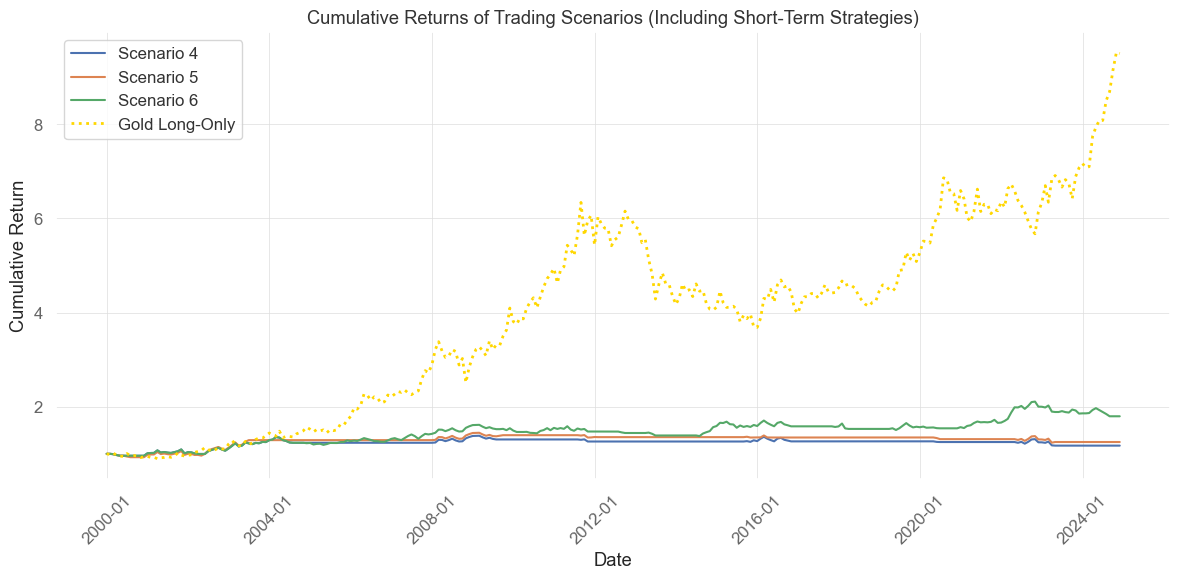

In [153]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plotting
plt.figure(figsize=(12, 6))

# Existing scenarios (1-3 and combined)
# plt.plot(cumulative_returns_scenario1.index, cumulative_returns_scenario1, label='Scenario 1')
# plt.plot(cumulative_returns_scenario2.index, cumulative_returns_scenario2, label='Scenario 2')
# plt.plot(cumulative_returns_scenario3.index, cumulative_returns_scenario3, label='Scenario 3')
# plt.plot(cumulative_returns_combined.index, cumulative_returns_combined, label='Combined Strategy LT', linewidth=2, linestyle='--')

# # New scenarios (7-9)
# plt.plot(cumulative_returns_scenario7.index, cumulative_returns_scenario4, label='Scenario 4')
# plt.plot(cumulative_returns_scenario8.index, cumulative_returns_scenario5, label='Scenario 5')
# plt.plot(cumulative_returns_scenario9.index, cumulative_returns_scenario6, label='Scenario 6')
# plt.plot(cumulative_returns_combined_ST.index, cumulative_returns_combined, label='Combined Strategy ST', linewidth=2, linestyle='--')

# New scenarios (10-12)
plt.plot(cumulative_returns_scenario10.index, cumulative_returns_scenario4, label='Scenario 4')
plt.plot(cumulative_returns_scenario11.index, cumulative_returns_scenario5, label='Scenario 5')
plt.plot(cumulative_returns_scenario12.index, cumulative_returns_scenario6, label='Scenario 6')

# Gold Long-Only Strategy
plt.plot(cumulative_returns_gold.index, cumulative_returns_gold, label='Gold Long-Only', linewidth=2, linestyle=':', color='gold')

# Formatting
plt.title('Cumulative Returns of Trading Scenarios (Including Short-Term Strategies)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)

# Date formatting for x-axis
date_format = mdates.DateFormatter('%Y-%m')
ax = plt.gca()
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [154]:
# Add new scenarios to the combined performance DataFrame
combined_performance_new = pd.concat(
    [
        performance_scenario4.set_index('Metric'),
        performance_scenario5.set_index('Metric'),
        performance_scenario6.set_index('Metric'),
        performance_combined.set_index('Metric'),
        performance_scenario10.set_index('Metric'),
        performance_scenario11.set_index('Metric'),
        performance_scenario12.set_index('Metric'),
        performance_combined_ST.set_index('Metric'),
        performance_gold.set_index('Metric')
    ],
    axis=1,
    keys=[
        'Scenario 4',
        'Scenario 5',
        'Scenario 6',
        'Combined',
        'Scenario 10',
        'Scenario 11',
        'Scenario 12',
        'Combined ST',
        'Gold Long-Only',
    ],
)

# Display the updated combined performance metrics
combined_performance_new


,Scenario 4,Scenario 5,Scenario 6,Combined,Scenario 10,Scenario 11,Scenario 12,Combined ST,Gold Long-Only
,Value,Value,Value,Value,Value,Value,Value,Value,Value
Metric,,,,,,,,,
CAGR,0.0064,0.0090,0.0237,0.0750,0.0181,0.0122,0.0227,0.0421,0.0942
Annualized Volatility,0.0547,0.0515,0.0768,0.1299,0.0593,0.0524,0.0766,0.1188,0.1601
Annualized Downside Deviation,0.0568,0.0621,0.0501,0.0900,0.0504,0.0486,0.0521,0.0774,0.0916
Sharpe Ratio,0.1179,0.1747,0.3090,0.5774,0.3047,0.2336,0.2966,0.3545,0.5887
Sortino Ratio,0.1134,0.1449,0.4740,0.8333,0.3587,0.2518,0.4358,0.5443,1.0291
Omega Ratio,1.2030,1.3286,1.3331,1.7334,1.4948,1.4270,1.3357,1.4508,1.6097
Max Drawdown,-0.1516,-0.1449,-0.1480,-0.2496,-0.1091,-0.1136,-0.2321,-0.3014,-0.4188
Calmar Ratio,0.0425,0.0621,0.1604,0.3004,0.1657,0.1078,0.0979,0.1397,0.2250


In [155]:
# Create a dictionary of all strategy returns
strategy_returns = {
    'Scenario 4': monthly_returns_scenario4,
    'Scenario 5': monthly_returns_scenario5,
    'Scenario 6': monthly_returns_scenario6,
    'Combined (LT)': monthly_returns_combined,
    'Scenario 10': monthly_returns_scenario10,
    'Scenario 11': monthly_returns_scenario11,
    'Scenario 12': monthly_returns_scenario12,
    'Combined (ST)': monthly_returns_combined_ST,
    'Gold Long-Only': gold_returns_monthly,
    'Base Portfolio': returns_monthly['ports_pctchange']
}

# Convert the dictionary to a DataFrame
returns_df = pd.DataFrame(strategy_returns)

# Ensure all data is aligned by reindexing with the union of all dates
all_dates = returns_df.index.dropna().unique()
returns_df = returns_df.reindex(all_dates).sort_index()

# Drop rows with all NaN values
returns_df.dropna(how='all', inplace=True)


In [156]:
returns_df

,Scenario 4,Scenario 5,Scenario 6,Combined (LT),Scenario 10,Scenario 11,Scenario 12,Combined (ST),Gold Long-Only,Base Portfolio
1999-12-31,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2000-01-31,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0156,-0.0295
2000-02-29,-0.0078,-0.0078,-0.0078,-0.0104,-0.0078,-0.0078,-0.0078,-0.0286,0.0307,-0.0060
2000-03-31,-0.0188,-0.0188,-0.0188,-0.0445,-0.0217,-0.0126,-0.0217,-0.0158,-0.0449,0.0660
2000-04-30,-0.0148,-0.0145,-0.0148,0.0159,0.0000,0.0000,0.0000,0.0000,-0.0198,-0.0197
...,...,...,...,...,...,...,...,...,...,...
2024-07-31,0.0000,0.0000,-0.0226,0.0343,0.0000,0.0000,0.0000,0.0394,0.0519,0.0155
2024-08-31,0.0000,0.0000,-0.0264,0.0306,0.0000,0.0000,0.0000,0.0226,0.0228,0.0188
2024-09-30,0.0000,0.0000,0.0000,0.0519,0.0000,0.0000,0.0000,0.0519,0.0524,0.0169
2024-10-31,0.0000,0.0000,0.0000,0.0411,0.0000,0.0000,0.0000,0.0411,0.0415,-0.0155


In [157]:
# Calculate the correlation matrix
correlation_matrix = returns_df.corr()


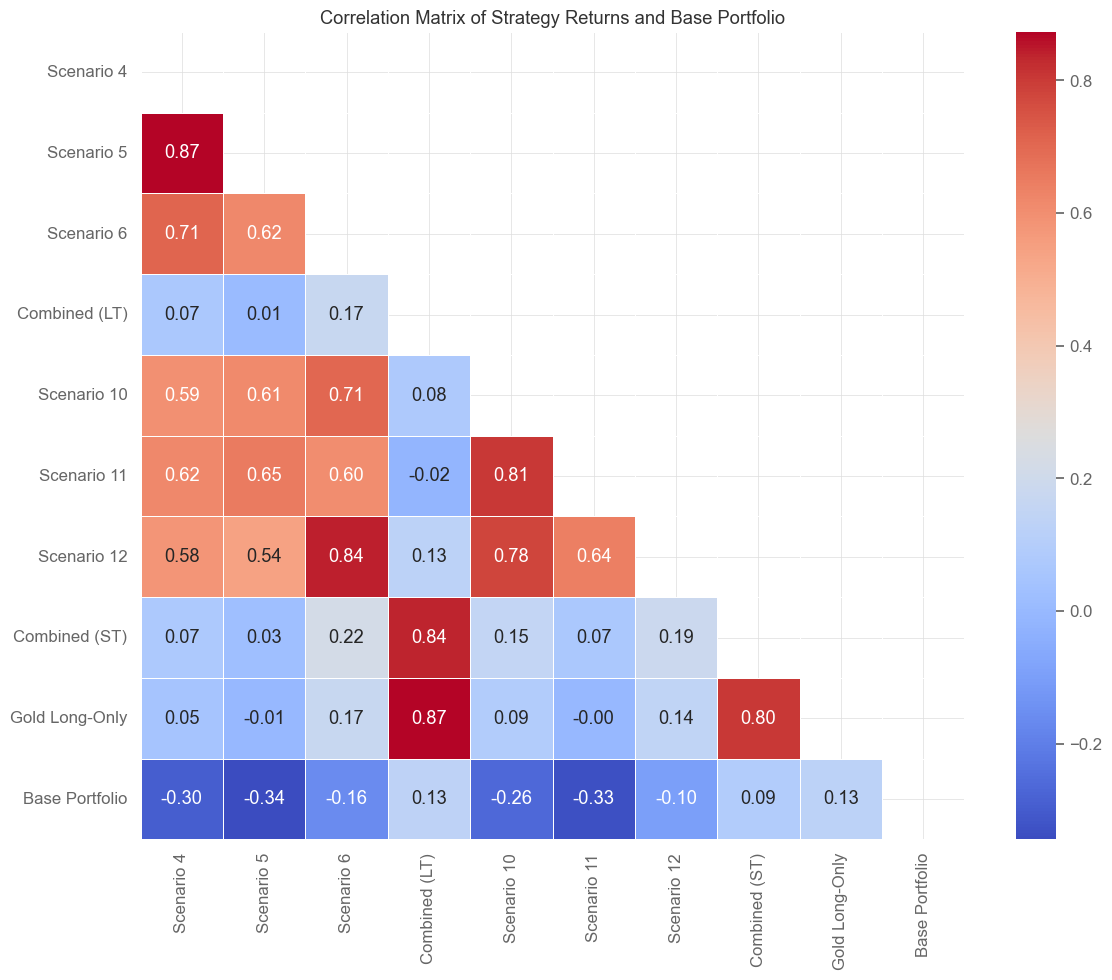

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle (optional)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Draw the heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Add title and adjust layout
plt.title('Correlation Matrix of Strategy Returns and Base Portfolio')
plt.tight_layout()

# Show the plot
plt.show()
